In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import os.path as path
import sklearn.metrics
import xgboost as xgb
import mlflow

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mape
from sklearn.metrics import mean_squared_error as mse
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features, extract_relevant_features, select_features


%matplotlib inline

In [2]:
sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (7, 5), 'figure.dpi': 120})

/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
df = pd.read_csv('../data/raw/stoloto_data.csv',
                       sep=',',
                       parse_dates=['date'], index_col=0)
df.head()

,ops_num,game_code,circulation,ufps_num,postamt_num,sales,date
0,117463,7105,216,2,165,57,2017-01-15
2,117218,7105,217,2,165,17,2017-01-22
4,109518,7105,218,2,484,16,2017-01-29
8,119311,7105,209,2,306,22,2016-11-27
13,105043,7105,212,2,224,25,2016-12-18


In [4]:
# planning horizon
ph = 14

/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# timeseries = pd.DataFrame(df.iloc[:, :1])
# timeseries['id'] = 0

extracted_features = extract_features(df, column_id="ops_num", column_kind="game_code", column_value="sales", column_sort="date", impute_function=impute) 
extracted_features.head()

Feature Extraction: 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


,7105__variance_larger_than_standard_deviation,7105__has_duplicate_max,7105__has_duplicate_min,7105__has_duplicate,7105__sum_values,7105__abs_energy,7105__mean_abs_change,7105__mean_change,7105__mean_second_derivative_central,7105__median,...,7103__fourier_entropy__bins_2,7103__fourier_entropy__bins_3,7103__fourier_entropy__bins_5,7103__fourier_entropy__bins_10,7103__fourier_entropy__bins_100,7103__permutation_entropy__dimension_3__tau_1,7103__permutation_entropy__dimension_4__tau_1,7103__permutation_entropy__dimension_5__tau_1,7103__permutation_entropy__dimension_6__tau_1,7103__permutation_entropy__dimension_7__tau_1
103132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105005,1.0,0.0,0.0,1.0,5324.0,757384.0,29.414414,0.189189,-0.059091,36.0,...,0.372481,0.766798,1.032496,1.655561,3.477232,1.787136,3.105722,4.134775,4.556225,4.650361
105043,1.0,0.0,0.0,1.0,2917.0,153701.0,15.051546,-0.082474,-0.010417,23.0,...,0.617242,0.830027,1.262577,1.867884,3.404463,1.762421,2.998610,4.014683,4.383525,4.549908
105066,1.0,0.0,0.0,1.0,1390.0,53322.0,12.209677,0.048387,0.024590,19.0,...,0.132691,0.354599,0.793748,1.331704,3.144011,1.741195,2.987269,3.923088,4.127134,4.110874
105264,1.0,0.0,1.0,1.0,1960.0,106936.0,12.192308,0.173077,-0.004854,14.0,...,0.593615,0.837499,1.235145,1.822476,3.538273,1.766637,3.083514,4.277879,4.605115,4.672829


In [5]:
ts = pd.read_csv('../data/preprocessed/knn_imputated_ts.csv',
                       sep=',',
                       parse_dates=['date'], index_col=0)
ts.head()

,7101_105005,7101_105043,7101_105264,7101_105523,7101_105554,7101_105568,7101_107589,7101_109263,7101_109382,7101_109383,...,7175_119311,7175_119619,7175_121374,7175_124460,7175_125222,7175_125239,7175_127204,7175_127276,7175_129110,7175_129164
date,,,,,,,,,,,,,,,,,,,,,
2016-11-06,19.250000,23.0,17.000000,21.0,28.000000,15.0,18.000000,13.0,29.222222,17.0,...,14.0,18.0,19.0,15.0,28.0,42.0,15.0,29.0,34.0,17.0
2016-11-13,19.611111,23.0,17.000000,21.0,26.814815,18.5,17.777778,13.0,16.000000,17.0,...,14.0,18.0,19.0,15.0,28.0,42.0,15.0,29.0,34.0,17.0
2016-11-20,19.000000,23.0,17.000000,21.0,30.000000,18.0,18.000000,13.0,33.000000,17.0,...,14.0,18.0,19.0,15.0,28.0,42.0,15.0,29.0,34.0,17.0
2016-11-27,19.500000,23.0,17.000000,21.0,26.000000,21.0,18.000000,13.0,38.666667,17.0,...,14.0,18.0,19.0,15.0,28.0,42.0,15.0,29.0,34.0,17.0
2016-12-04,20.333333,23.0,16.333333,20.5,24.444444,20.0,17.333333,13.0,16.000000,17.0,...,14.0,18.0,19.0,15.0,28.0,42.0,15.0,29.0,34.0,17.0


In [34]:
# Calculate sales included other ts

general_sales = df.sort_values(by=['date']).groupby('date')['sales'].sum().shift(14).dropna()
game_code_sales = df.sort_values(by=['date']).groupby(['date', 'game_code'])['sales'].sum().unstack().shift(14).dropna()
ops_num_sales = df.sort_values(by=['date']).groupby(['date', 'ops_num'])['sales'].sum().unstack().shift(14).dropna()

/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
from datetime import timedelta

def holiday_week(gamedate, holidaydates):
    holiday_dates = pd.to_datetime(holidaydates)
    game_date = pd.to_datetime(gamedate)
    for holiday_date in holiday_dates:
        #print(game_date)
        if (holiday_date <= game_date) & (game_date < (holiday_date + timedelta(days=7))):
            return 1
    return 0

def week_before_holiday(gamedate, holidaydates):
    holiday_dates = pd.to_datetime(holidaydates)
    game_date = pd.to_datetime(gamedate)
    for holiday_date in holiday_dates:
        if (holiday_date <= game_date + timedelta(days=7)) & (game_date < holiday_date):
            return 1
    return 0

/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
# Holiday dummy features

ny_dates = ['2017-01-01', '2018-01-01', '2019-01-01']
df1 = ts.reset_index(inplace=False)
df1 = pd.DataFrame(df1['date'])
df1['NY_week'] = df1.apply(lambda x: holiday_week(x['date'], ny_dates), axis=1)
df1['week_before_NY'] = df1.apply(lambda x: week_before_holiday(x['date'], ny_dates), axis=1)
bday_dates = ['2016-10-18', '2017-10-18', '2018-10-18'] 
holiday_dates = ['2016-03-08', '2017-03-08', '2018-03-08', '2016-02-23', '2017-02-23', '2018-02-23', '2016-11-04', '2017-11-04', '2018-11-04']
df1['B-day_week'] = df1.apply(lambda x: holiday_week(x['date'], bday_dates), axis=1)
df1['holiday_week'] = df1.apply(lambda x: holiday_week(x['date'], holiday_dates), axis=1)
df1 = df1.set_index('date')
print(df1)

/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


            NY_week  week_before_NY  B-day_week  holiday_week
date                                                         
2016-11-06        0               0           0             1
2016-11-13        0               0           0             0
2016-11-20        0               0           0             0
2016-11-27        0               0           0             0
2016-12-04        0               0           0             0
...             ...             ...         ...           ...
2019-01-06        1               0           0             0
2019-01-13        0               0           0             0
2019-01-20        0               0           0             0
2019-01-27        0               0           0             0
2019-02-03        0               0           0             0

[118 rows x 4 columns]


In [5]:
X = pd.DataFrame(ts.iloc[:, 4].shift(14)).dropna()
y = ts.iloc[14:, 4]
X['mean'] = X.mean()
X['mean_w4'] = X['7101_105554'].rolling(4).mean()
X['mean_w8'] = X['7101_105554'].rolling(8).mean()
X['mean_w12'] = X['7101_105554'].rolling(12).mean()
X['deviation'] = X['7101_105554'] - X['7101_105554'].mean()
X['previous'] = X['7101_105554'].shift(1)
X = X.bfill()
X = X.drop(['7101_105554'], axis=1)
X.reset_index(inplace=True)

extracted_features = extract_features(X, column_id='date', column_sort="date", impute_function=impute) 

X_filtered = select_features(extracted_features, y, ml_task='regression')

X_train = extracted_features.iloc[:-14, :]
X_test = extracted_features.iloc[-14:, :]
y_train = y[:-14]
y_test = y[-14:]

regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=6
)
regressor.fit(X_train, y_train)
print(mse(y_test.to_numpy(), regressor.predict(X_test), squared=False))

Feature Extraction: 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


6.931941790032365


In [19]:
# Extract features

all_extracted_features = []
filtered_features = []

for i, col in enumerate(ts.columns):
    X = pd.DataFrame(ts.loc[:, col].shift(14)).dropna()
    y = ts.iloc[14:, i]
    X['mean'] = X[col].mean()
    X['mean_w4'] = X[col].rolling(4).mean()
    X['mean_w8'] = X[col].rolling(8).mean()
    X['mean_w12'] = X[col].rolling(12).mean()
    X['deviation'] = X[col] - X[col].mean()
    X['previous'] = X[col].shift(1)
    X = X.bfill()
    X = X.drop([col], axis=1)
    X.reset_index(inplace=True)

    extracted_features = extract_features(X, column_id='date', column_sort="date", impute_function=impute)
    all_extracted_features.append((col, extracted_features))
    filtered_features.append((col, select_features(extracted_features, y, ml_task='regression')))

Feature Extraction: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Feature Extraction: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


Feature Extraction: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


In [20]:
xgb_regressor = xgb.XGBRegressor(
        n_estimators=100,
        reg_lambda=1,
        gamma=0,
        max_depth=6
    )
tree_regressor = DecisionTreeRegressor()

/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
extracted_feat_mse_xgb = []
extracted_feat_mape_xgb = []
all_feat_mse_xgb = []
all_feat_mape_xgb = []

extracted_feat_mse_dtr = []
extracted_feat_mape_dtr = []
all_feat_mse_dtr = []
all_feat_mape_dtr = []

for col, extracted_features in all_extracted_features:
    X_train = extracted_features.iloc[:-14, :]
    X_test = extracted_features.iloc[-14:, :]
    y_train = y[:-14]
    y_test = y[-14:]
    
    xgb_regressor.fit(X_train, y_train)
    extracted_feat_mse_xgb.append(mse(y_test.to_numpy(), xgb_regressor.predict(X_test), squared=False))
    extracted_feat_mape_xgb.append(mape(y_test.to_numpy(), xgb_regressor.predict(X_test)))
    
    X_train = X_train.dropna(axis=1)
    X_test = X_test[X_train.columns]
    tree_regressor.fit(X_train, y_train)
    extracted_feat_mse_dtr.append(mse(y_test.to_numpy(), tree_regressor.predict(X_test), squared=False))
    extracted_feat_mape_dtr.append(mape(y_test.to_numpy(), tree_regressor.predict(X_test)))
    
    extracted_features['last_year_sales'] = pd.DataFrame(ts.loc[:, col].shift(14)).shift(52)
    extracted_features['general_sales'] = general_sales
    extracted_features['game_code_sales'] = game_code_sales[int(col[:4])]
    extracted_features['ops_num_sales'] = ops_num_sales[int(col[5:])]
    all_features = pd.concat([extracted_features, df1.iloc[14:, :]], axis=1, sort=False)
    
    X_all_train = all_features.iloc[:-14, :]
    X_all_test = all_features.iloc[-14:, :]
    
    xgb_regressor.fit(X_all_train, y_train)    
    all_feat_mse_xgb.append(mse(y_test.to_numpy(), xgb_regressor.predict(X_all_test), squared=False))
    all_feat_mape_xgb.append(mape(y_test.to_numpy(), xgb_regressor.predict(X_all_test)))
    
    X_all_train = X_all_train.dropna(axis=1)
    X_all_test = X_all_test[X_all_train.columns]
    tree_regressor.fit(X_all_train, y_train)    
    all_feat_mse_dtr.append(mse(y_test.to_numpy(), tree_regressor.predict(X_all_test), squared=False))
    all_feat_mape_dtr.append(mape(y_test.to_numpy(), tree_regressor.predict(X_all_test)))

/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
with mlflow.start_run(run_name='XGBoost_extr_features'):
    mlflow.log_metric("mape", np.mean(extracted_feat_mape_xgb))
    mlflow.log_metric("rmse", np.mean(extracted_feat_mse_xgb))
with mlflow.start_run(run_name='XGBoost_all_features'):
    mlflow.log_metric("mape", np.mean(all_feat_mape_xgb))
    mlflow.log_metric("rmse", np.mean(all_feat_mse_xgb))
with mlflow.start_run(run_name='DecTreeRegr_extr_features'):
    mlflow.log_metric("mape", np.mean(extracted_feat_mape_dtr))
    mlflow.log_metric("rmse", np.mean(extracted_feat_mse_dtr))
with mlflow.start_run(run_name='DecTreeRegr_all_features'):
    mlflow.log_metric("mape", np.mean(all_feat_mape_dtr))
    mlflow.log_metric("rmse", np.mean(all_feat_mse_dtr))

/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
print(np.mean(extracted_feat_mape))
print(np.mean(all_feat_mape))
print(np.mean(extracted_feat_mse))
print(np.mean(all_feat_mse))

44.726382278646476
44.91772591420207
108.83605484070105
108.83488753544539


/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


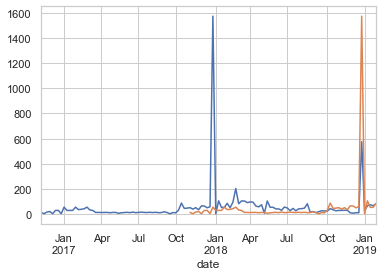

In [61]:
df.iloc[:, 145].plot()
df.iloc[:, 145].shift(52).plot()
plt.show()

In [48]:
filtered_feat_mse_xgb = []
filtered_feat_mape_xgb = []

for col, filtered_feature in filtered_features:
   
    filtered_feature['last_year_sales'] = pd.DataFrame(ts.loc[:, col].shift(14)).shift(52)
    filtered_feature['general_sales'] = general_sales
    filtered_feature['game_code_sales'] = game_code_sales[int(col[:4])]
    filtered_feature['ops_num_sales'] = ops_num_sales[int(col[5:])]
    all_features = pd.concat([filtered_feature, df1.iloc[14:, :]], axis=1, sort=False)
    
    X_train = all_features.iloc[:-14, :]
    X_test = all_features.iloc[-14:, :]
    y_train = y[:-14]
    y_test = y[-14:]
    
    xgb_regressor.fit(X_train, y_train)
    filtered_feat_mse_xgb.append(mse(y_test.to_numpy(), xgb_regressor.predict(X_test), squared=False))
    filtered_feat_mape_xgb.append(mape(y_test.to_numpy(), xgb_regressor.predict(X_test)))

with mlflow.start_run(run_name='XGBoost_filtred_features'):
    mlflow.log_metric("mape", np.mean(filtered_feat_mape_xgb))
    mlflow.log_metric("rmse", np.mean(filtered_feat_mse_xgb))

4.410203819988536
5.8492722788255485


/Users/alenalapteva/anaconda3/envs/alapteva-time-series/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The best result shows XGBoost on extracted features without custom ones.